In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import geopandas as gpd
import xarray as xr

from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('mode.chained_assignment', None)

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



# WUE on image data (without validation), 2021-2022

This exercise has the following parts:
1. Scaling of Landsat-8/9-based evapotranspiration (ET) simulated with the two-source energy balance (TSEB) from instantaneous to seasonal values *with ERA5 reanalysis data*

    1.1 - example of the maiz field (point)
    
    1.2 - application to the whole datacube (lat, lon, time)
    
2. Computation of the WUE per field from measured yields

Bonus 1:

3. Simulation of dry-matter productivity with light use efficiency (LUE) model and Landsat-8/9 normalized difference vegetation index (NDVI)
4. Computation of WUE per pixel

Bonus 2*:

5. Comparison of our simulations to potential ET (PET)

Data for this exercise (field boundaries and yields) were kindly provided by the organizers of the training https://landtraining2022.esa.int/

In [2]:
data_path = Path('2-wue-koszeg')

# 0. Shapes and measured yield

can be better visualized in QGIS

In [3]:
gdf = gpd.read_file(data_path / 'esa_field_trip_2022.shp')

<AxesSubplot:>

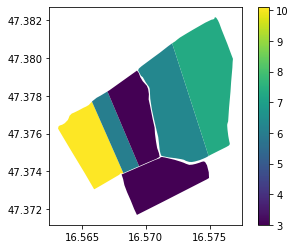

In [4]:
gdf.plot(column='yield', legend=True)

In [5]:
gdf['planting'] = pd.to_datetime(gdf.planting, format='%d.%m.%Y')
gdf['harvesting'] = pd.to_datetime(gdf.harvesting, format='%d.%m.%Y')
gdf['los'] = (gdf.harvesting - gdf.planting).dt.days

In [6]:
gdf

,id,area,planting,harvesting,yield,2022_crop,geometry,los
0,1,9.940,2022-05-11,2022-10-24,10.1,maize,"POLYGON ((16.56578 47.37769, 16.56824 47.37391...",166
1,6,10.046,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((16.56810 47.37382, 16.56813 47.37385...",317
2,2,4.939,2021-11-14,2022-07-21,6.0,oat,"POLYGON ((16.56700 47.37823, 16.56947 47.37427...",249
3,2,9.267,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((16.56947 47.37427, 16.56700 47.37823...",317
4,4,15.231,2021-11-14,2022-07-20,6.3,w. wheat,"POLYGON ((16.57206 47.38079, 16.57492 47.37481...",248
5,4,17.791,2021-10-13,2022-07-04,7.3,w. barley,"POLYGON ((16.57492 47.37481, 16.57206 47.38079...",264


reprojecting to UTM CRS otherwise problems with cropping fields

In [7]:
gdf_utm = gdf.to_crs(32633)

<AxesSubplot:>

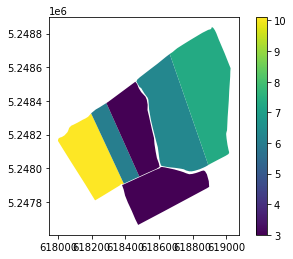

In [8]:
gdf_utm.plot(column='yield', legend=True)

# 1. Scaling of Landsat-8/9-based evapotranspiration (ET) simulated with the two-source energy balance (TSEB) from instantaneous to seasonal values *with ERA5 reanalysis data*

TSEB model was explained to you on Tuesday

There is a Google Earth Engine version of it that runs on Landsat images: https://code.earthengine.google.com/cf6e11158e3e4d5ab2acbce994882ed6?noload=true

The resulting images are in the folder *GEE_esa_fr*

The model returns instantaneous (at the time of satellite overpass) latent heat flux (LE)

We are going to scale it to daily ET and further to fill the gaps in between satellite overpasses based on net radiation and evaporative fraction (EF)

ERA5 reanalysis data was extracted from Google Earth Engine dataset https://code.earthengine.google.com/6d6f070cd572bf3e19625ed3408bd1f0?noload=true, single nearest pixel

## what is in a single image

same as in exercise 1-wue-france.


- bands of Landsat surface reflectance (SR_*), surface temperature (ST_*), quality flags
    - computed NDVI, albedo, radiometric temperature, LAI
- ERA5 meteorological data at the time of overpass
    - radiation, temperature, wind speed
- TSEB computed values
    - soil, canopy and scene temperature, net radiation, instantaneous heat fluxes


In [9]:
ls8 = xr.open_dataset(data_path / 'GEE_esa' / '1_2_LC08_189027_20220620_20220620T09.tif')
band_names = ls8.band_data.attrs['long_name'] 
print(list(band_names))
ls8.band_data.attrs = dict()

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'albedo', 'albedo_vis', 'albedo_nir', 'NDVI', 'radiometric_temperature', 'LAI', 'surface_pressure', 'air_temperature', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_solar_radiation_downwards_hourly', 'surface_thermal_radiation_downwards_hourly', 'wind_speed', 'solar_radiation', 'thermal_radiation', 'Tc', 'Ts', 'Tac', 'Hc', 'Hs', 'LEc', 'LEs', 'Ra', 'Rs', 'Rx', 'Ustar', 'alphaPT', 'iteration', 'LE', 'H', 'G', 'Rn', 'Rns', 'Rnc', 'ETd', 'EF']


In [10]:
band_names.index('Rn'), band_names.index('G'), band_names.index('LE'), band_names.index('surface_solar_radiation_downwards_hourly'), band_names.index('NDVI')

(50, 49, 47, 29, 22)

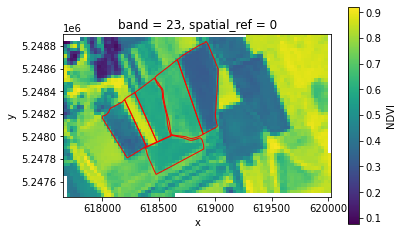

In [11]:
ax = plt.subplot()
ls8.sel(band=23).squeeze().band_data.plot(ax=ax, cbar_kwargs={'label': 'NDVI'})
gdf_utm.plot(ax=ax, facecolor='none', edgecolor='red');

## 1.1 - example of the maiz field (point)

- crop per crop

In [12]:
gdf_utm

,id,area,planting,harvesting,yield,2022_crop,geometry,los
0,1,9.940,2022-05-11,2022-10-24,10.1,maize,"POLYGON ((618196.610 5248325.801, 618390.967 5...",166
1,6,10.046,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618380.730 5247899.310, 618382.926 5...",317
2,2,4.939,2021-11-14,2022-07-21,6.0,oat,"POLYGON ((618287.225 5248387.606, 618483.076 5...",249
3,2,9.267,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618483.076 5247950.694, 618287.225 5...",317
4,4,15.231,2021-11-14,2022-07-20,6.3,w. wheat,"POLYGON ((618663.927 5248679.234, 618893.223 5...",248
5,4,17.791,2021-10-13,2022-07-04,7.3,w. barley,"POLYGON ((618893.223 5248019.231, 618663.927 5...",264


In [13]:
pol_i = gdf_utm[gdf_utm['2022_crop'] == 'maize']

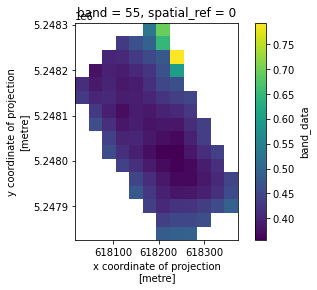

In [14]:
ls8_maize = ls8.rio.clip(pol_i.geometry)
ax = plt.subplot()
ls8_maize.sel(band=55).squeeze().band_data.plot(ax=ax)
gdf_utm.plot(ax=ax, color=None, edgecolor='red', alpha=0);

### Looping through the files

In [15]:
df_path = pd.DataFrame({'path': (data_path / 'GEE_esa').glob('*.tif')})
df_path['date'] = df_path.path.apply(lambda row: pd.to_datetime(row.name.split('_')[-1].replace('T09.tif', '')))
df_path = df_path.sort_values('date')
df_path.head(7)

,path,date
0,2-wue-koszeg\GEE_esa\1_2_LC08_189027_20210804_...,2021-08-04
1,2-wue-koszeg\GEE_esa\1_2_LC08_189027_20210820_...,2021-08-20
2,2-wue-koszeg\GEE_esa\1_2_LC08_189027_20210905_...,2021-09-05
3,2-wue-koszeg\GEE_esa\1_2_LC08_189027_20210921_...,2021-09-21
4,2-wue-koszeg\GEE_esa\1_2_LC08_189027_20211023_...,2021-10-23
21,2-wue-koszeg\GEE_esa\2_LC09_189027_20211105_20...,2021-11-05
5,2-wue-koszeg\GEE_esa\1_2_LC08_189027_20211108_...,2021-11-08


In [16]:
tiffs = []
date_val = []

for _, row in tqdm(list(df_path.iterrows()), 'tiffs'):
    tif = xr.open_dataset(row.path)
    tif.band_data.attrs = dict()
    tiffs.append(tif)
    
    tif_crop = tif.rio.clip(pol_i.geometry)
    
    ef = tif_crop.sel(band=48) / (tif_crop.sel(band=51) - tif_crop.sel(band=50))  # LE / (Rn - G) = EF
    
    # break
    res_i = {
        'date': row.date, 
        'EF': ef.band_data.mean().values
        }
    
    date_val.append(res_i)
    

tiffs:   0%|          | 0/36 [00:00<?, ?it/s]

Text(0, 0.5, 'evaporative fraction')

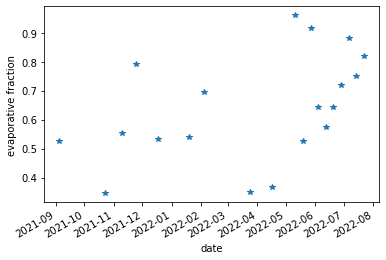

In [17]:
df = pd.DataFrame(date_val)
df = df.set_index('date')
df = df.sort_index()
df = df.astype(float)
df.EF.plot(style='*')
plt.ylabel('evaporative fraction')

### upscaling of instantaneous LE to daily ET

This is done on the assumption of constant ratio of LE to available energy (Rn - G, net radiation minus ground heat flux) throughout a day

$\dfrac{LE_{inst}}{(RN_{inst} - G_{inst})} \approx \dfrac{LE_{24}}{(RN_{24} - G_{24})} $

ERA5 reanalysis data was extracted from Google Earth Engine dataset https://code.earthengine.google.com/637716142322dd89703cb36cc7bb3d23?noload=true, single nearest pixel

In [18]:
df_met = pd.read_csv(data_path / 'koszeg_era5.csv')
df_met.index = pd.to_datetime(df_met['system:index'].str.replace('_0', ''))
df_met.index.name = 'date'
df_met.head()

,system:index,lwnet_mean,p_mean,rin_mean,rli_mean,swnet_mean,ta_mean,vpd_mean,ws_mean,.geo
date,,,,,,,,,,
2021-01-01,2021-01-01_0,-68.587870,975.668122,58.818565,238.082674,51.854306,-0.205066,0.781037,1.939189,"{""type"":""Point"",""coordinates"":[16.566160024130..."
2021-01-02,2021-01-02_0,-34.853403,978.569733,41.138380,284.915324,36.282431,2.436085,0.589518,1.803777,"{""type"":""Point"",""coordinates"":[16.566160024130..."
2021-01-03,2021-01-03_0,-18.213194,976.879259,29.095324,311.855775,25.658681,3.810264,0.438822,1.831700,"{""type"":""Point"",""coordinates"":[16.566160024130..."
2021-01-04,2021-01-04_0,-13.378912,978.282157,22.541065,310.498576,19.903588,2.142332,0.251995,1.544246,"{""type"":""Point"",""coordinates"":[16.566160024130..."
2021-01-05,2021-01-05_0,-28.447593,976.870675,40.379120,299.951331,35.677176,2.831466,0.771312,1.025689,"{""type"":""Point"",""coordinates"":[16.566160024130..."


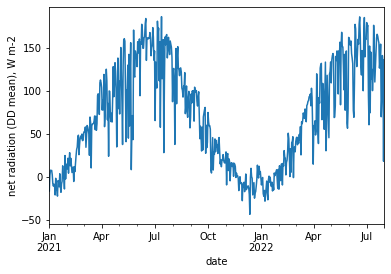

In [19]:
df_met['rn_24'] = df_met.swnet_mean + df_met.lwnet_mean
ax = df_met.rn_24.plot()
ax.set_ylabel('net radiation (DD mean), W m-2');

In [20]:
df = df.join(df_met['rn_24'])

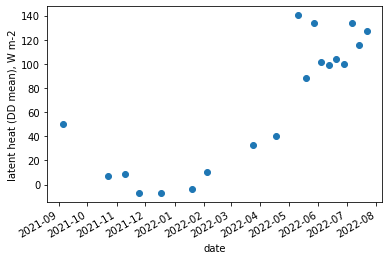

In [21]:
df['le_24'] = df.EF * df.rn_24
ax = df.le_24.plot(style='o')
ax.set_ylabel('latent heat (DD mean), W m-2');

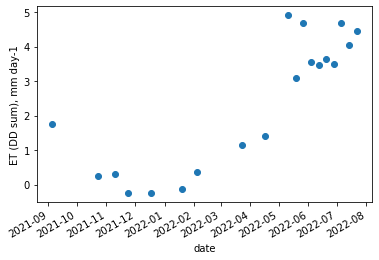

In [22]:
df['et_24'] = df.le_24 * 0.035  

ax = df.et_24.plot(style='o', label='EF scaling')
ax.set_ylabel('ET (DD sum), mm day-1');

### gap filling ET (in between observations)

also with evaporative fraction

In [23]:
ef_linear = df.EF.resample('D').mean().interpolate()
ef_ma30_wrong = ef_linear.rolling('30D').mean()
ef_ma30 = ef_ma30_wrong.shift(-15)

Text(0, 0.5, 'evaporative fraction')

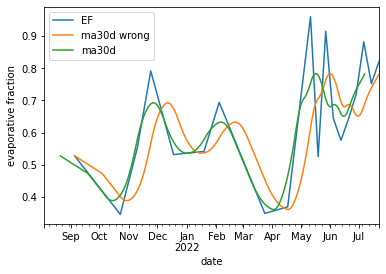

In [24]:
ef_linear.plot()
ef_ma30_wrong.plot(label='ma30d wrong')
ef_ma30.plot(label='ma30d')
ax.set_ylabel('evaporative fraction');
plt.legend()
plt.ylabel('evaporative fraction')

In [25]:
df_met = df_met.join(ef_ma30)
df_met['ET'] = df_met.EF * df_met.rn_24 * 0.035

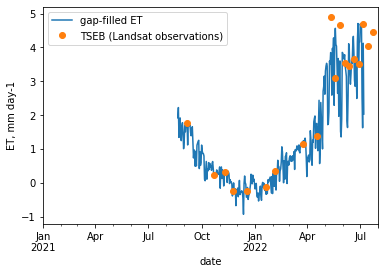

In [26]:
ax = df_met.ET.plot(label='gap-filled ET')
df.et_24.plot(ax=ax, style='o', label='TSEB (Landsat observations)')
ax.legend()
ax.set_ylabel('ET, mm day-1');

## 1.2 - application to the whole datacube (lat, lon, time)

In [27]:
tif_all = xr.concat(tiffs, dim='date')

In [28]:
tif_all['date'] = [x['date'] for x in date_val]

In [29]:
ef_all = tif_all.sel(band=48) / (tif_all.sel(band=51) - tif_all.sel(band=50))  # LE / (Rn - G) = EF
ef_all

<xarray.Dataset>
Dimensions:      (x: 79, y: 48, date: 36)
Coordinates:
    band         int32 48
  * x            (x) float64 6.177e+05 6.177e+05 6.177e+05 ... 6.2e+05 6.2e+05
  * y            (y) float64 5.249e+06 5.249e+06 ... 5.248e+06 5.247e+06
    spatial_ref  int32 0
  * date         (date) datetime64[ns] 2021-08-04 2021-08-20 ... 2022-07-22
Data variables:
    band_data    (date, y, x) float32 nan nan nan nan nan ... nan nan nan nan

interpolation in time dimension

In [30]:
ef_all = ef_all.resample({'date': 'D'}).mean()
ef_all

<xarray.Dataset>
Dimensions:      (date: 353, x: 79, y: 48)
Coordinates:
  * date         (date) datetime64[ns] 2021-08-04 2021-08-05 ... 2022-07-22
    band         int32 48
  * x            (x) float64 6.177e+05 6.177e+05 6.177e+05 ... 6.2e+05 6.2e+05
  * y            (y) float64 5.249e+06 5.249e+06 ... 5.248e+06 5.247e+06
    spatial_ref  int32 0
Data variables:
    band_data    (date, y, x) float32 nan nan nan nan nan ... nan nan nan nan

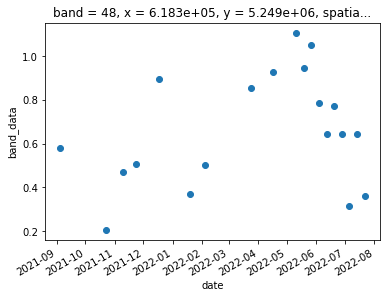

In [31]:
ef_all.band_data[:, 10, 20].plot(marker='o')

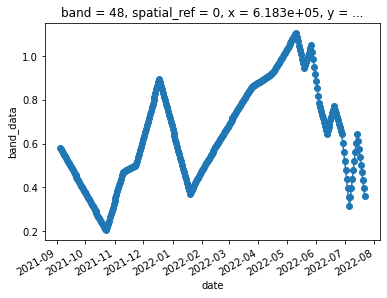

In [32]:
ef_all.interpolate_na(dim='date').band_data[:, 10, 20].plot(marker='o')

In [33]:
ef_all = ef_all.interpolate_na(dim='date')

In [34]:
ef_all['rn_24'] = df_met[ef_all.date.min().values:ef_all.date.max().values].rn_24

In [35]:
ef_all['et_24'] = ef_all.rn_24 * ef_all.band_data * 0.035

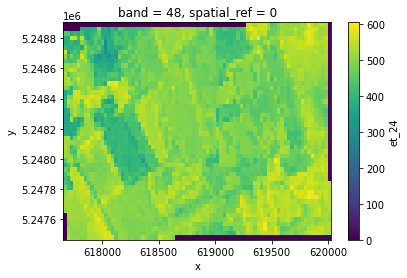

In [36]:
ef_all.sum(dim='date').et_24.plot();

# 2. Computation of the WUE per field from measured yields

In [37]:
gdf_utm

,id,area,planting,harvesting,yield,2022_crop,geometry,los
0,1,9.940,2022-05-11,2022-10-24,10.1,maize,"POLYGON ((618196.610 5248325.801, 618390.967 5...",166
1,6,10.046,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618380.730 5247899.310, 618382.926 5...",317
2,2,4.939,2021-11-14,2022-07-21,6.0,oat,"POLYGON ((618287.225 5248387.606, 618483.076 5...",249
3,2,9.267,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618483.076 5247950.694, 618287.225 5...",317
4,4,15.231,2021-11-14,2022-07-20,6.3,w. wheat,"POLYGON ((618663.927 5248679.234, 618893.223 5...",248
5,4,17.791,2021-10-13,2022-07-04,7.3,w. barley,"POLYGON ((618893.223 5248019.231, 618663.927 5...",264


In [38]:
et_tifs = []

for i, row in gdf_utm.iterrows():
    ef_all_crop = ef_all.rio.clip([row.geometry])
    et_seasonal = ef_all_crop.sel(date=slice(row.planting, row.harvesting)).sum(dim='date').et_24#.plot()
    et_tifs.append(et_seasonal)
    gdf_utm.loc[i, 'et_sum'] = et_seasonal.mean().values
    # print(et_seasonal)

In [39]:
gdf_utm

,id,area,planting,harvesting,yield,2022_crop,geometry,los,et_sum
0,1,9.940,2022-05-11,2022-10-24,10.1,maize,"POLYGON ((618196.610 5248325.801, 618390.967 5...",166,142.273508
1,6,10.046,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618380.730 5247899.310, 618382.926 5...",317,282.279199
2,2,4.939,2021-11-14,2022-07-21,6.0,oat,"POLYGON ((618287.225 5248387.606, 618483.076 5...",249,158.497976
3,2,9.267,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618483.076 5247950.694, 618287.225 5...",317,238.944472
4,4,15.231,2021-11-14,2022-07-20,6.3,w. wheat,"POLYGON ((618663.927 5248679.234, 618893.223 5...",248,223.816096
5,4,17.791,2021-10-13,2022-07-04,7.3,w. barley,"POLYGON ((618893.223 5248019.231, 618663.927 5...",264,257.171402


In [40]:
gdf_utm['wue'] = gdf_utm['yield'] / gdf_utm['et_sum'] * 1e3  # kg mm-1 ha-1
gdf_utm

,id,area,planting,harvesting,yield,2022_crop,geometry,los,et_sum,wue
0,1,9.940,2022-05-11,2022-10-24,10.1,maize,"POLYGON ((618196.610 5248325.801, 618390.967 5...",166,142.273508,70.990026
1,6,10.046,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618380.730 5247899.310, 618382.926 5...",317,282.279199,10.627776
2,2,4.939,2021-11-14,2022-07-21,6.0,oat,"POLYGON ((618287.225 5248387.606, 618483.076 5...",249,158.497976,37.855373
3,2,9.267,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618483.076 5247950.694, 618287.225 5...",317,238.944472,12.555218
4,4,15.231,2021-11-14,2022-07-20,6.3,w. wheat,"POLYGON ((618663.927 5248679.234, 618893.223 5...",248,223.816096,28.148110
5,4,17.791,2021-10-13,2022-07-04,7.3,w. barley,"POLYGON ((618893.223 5248019.231, 618663.927 5...",264,257.171402,28.385738


## spatial accumulated ET

keep in mind, maize does not have full growing season

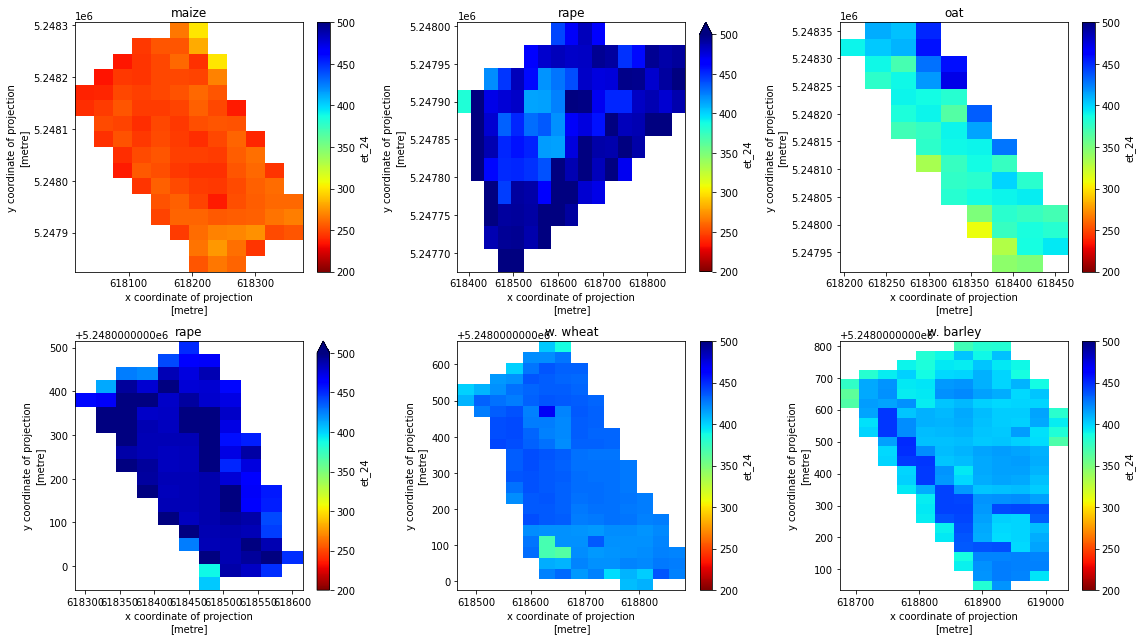

In [41]:
_, axs = plt.subplots(2, 3, figsize=(16, 9), tight_layout=True)
axs = axs.flatten()

for i in gdf_utm.index:
    ax = axs[i]
    crop = gdf_utm['2022_crop'][i]
    # if crop == 'maize':
    #     continue
    et_tifs[i].where(et_tifs[i] != 0).plot(ax=ax, cmap='jet_r', vmin=200, vmax=500)  # RdBu
    ax.set_title(crop)

# BONUS 1
# 3. Simulation of dry-matter productivity with light use efficiency (LUE) model and Landsat-8/9 normalized difference vegetation index (NDVI)

## is ndvi OK?

In [42]:
ndvi_all = tif_all.sel(band=23).squeeze().resample({'date': 'D'}).mean().interpolate_na(dim='date') #.band_data[:, 10, 20].plot(marker='o')

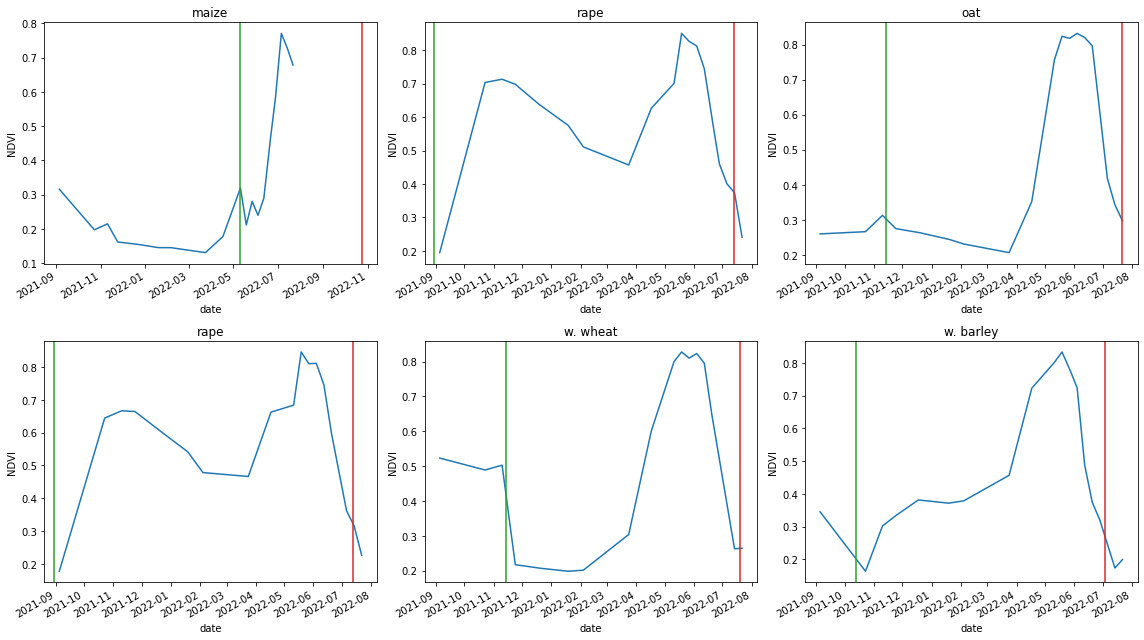

In [43]:
_, axs = plt.subplots(2, 3, figsize=(16, 9), tight_layout=True)
axs = axs.flatten()

ndvis = []

for i, row in gdf_utm.iterrows():
    ax = axs[i]
    ndvi_all_i = ndvi_all.rio.clip([row.geometry])
    ndvi_all_i.mean(dim=('x','y')).band_data.plot(ax=ax)
    ax.set_title(row['2022_crop'])
    ax.axvline(row.planting, c='tab:green')
    ax.axvline(row.harvesting, c='tab:red')
    ax.set_ylabel('NDVI')
    # print(et_seasonal)

## let's coin a model

$ GPP \ \text{[g C m-2 day-1]} = LUE_{MAX} * f(Ta) * f(VPD) * fpar * (SW\_IN * 0.45) $

- lue_max - light use efficiency, g C MJ-1
- f(Ta) - air temperature dependence (stress function, 0 => stress, 1 => ok)
- f(VPD) - vapour pressure deficit dependence (stress function, 0 => stress, 1 => ok)
- fpar - fraction of absorbed photosynthetically active radiation
- (SW_IN * 0.45) - photosynthetically active radiation (PAR) accumulated over the day, 45% of total incoming radiation

The values of parameters are from He et al., 2018 https://doi.org/10.3390/rs10030372

In [44]:
lue_max = 2.55  # gC MJ-1
vpd_max = 6940  # Pa
vpd_min = 1  # Pa
ta_max = 45.85  # C
ta_min = -23.15  # C

df_met['ta_stress'] = (df_met.ta_mean - ta_min)/(ta_max - ta_min)
df_met.loc[df_met.ta_mean > ta_max, 'ta_stress'] = 1
df_met.loc[df_met.ta_mean < ta_min, 'ta_stress'] = 0


df_met['vpd_stress'] = (vpd_max - df_met.vpd_mean)/(vpd_max - vpd_min)
df_met.loc[df_met.vpd_mean > vpd_max, 'vpd_stress'] = 0
df_met.loc[df_met.vpd_mean < vpd_min, 'vpd_stress'] = 1

<AxesSubplot:xlabel='date'>

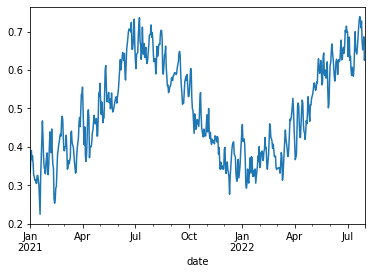

In [45]:
df_met.ta_stress.plot()

<AxesSubplot:xlabel='date'>

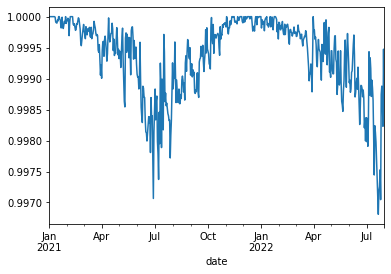

In [46]:
df_met.vpd_stress.plot()

### time-series

Text(0, 0.5, 'NDVI')

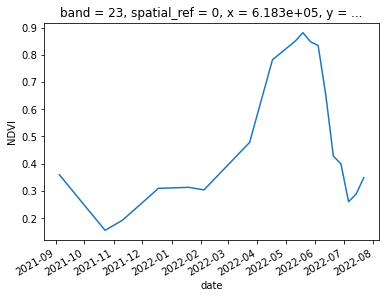

In [47]:
ndvi_random = ndvi_all.band_data[:, 10, 20]
ndvi_random.plot()
plt.ylabel('NDVI')

Text(0, 0.5, 'fpar')

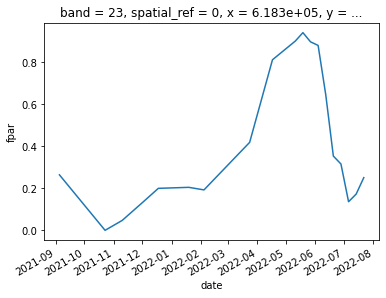

In [48]:
ndvi_max = ndvi_random.max()
ndvi_min = ndvi_random.min()

fpar_max = 0.95
fpar_min = 0.01

fpar = (ndvi_random - ndvi_min) / (ndvi_max - ndvi_min) * (fpar_max - fpar_min)
fpar.plot()
plt.ylabel('fpar')

In [49]:
df_met_i = df_met[ndvi_random.date.min().values: ndvi_random.date.max().values]

In [50]:
gpp = lue_max * df_met_i.ta_stress * df_met_i.vpd_stress * fpar * df_met_i.rin_mean * (60*60*24 * 1e-6) * 0.45  # gC m-2 day-1

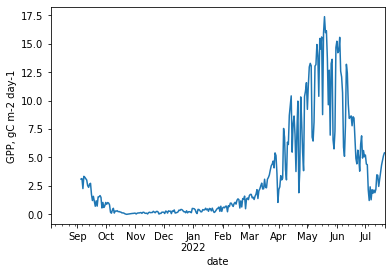

In [51]:
gpp.plot()
plt.ylabel('GPP, gC m-2 day-1');

In [52]:
dmp = gpp / 12 * (12+2+16) * 0.5 * 1e4 * 1e-3  # kg ha-1

### images

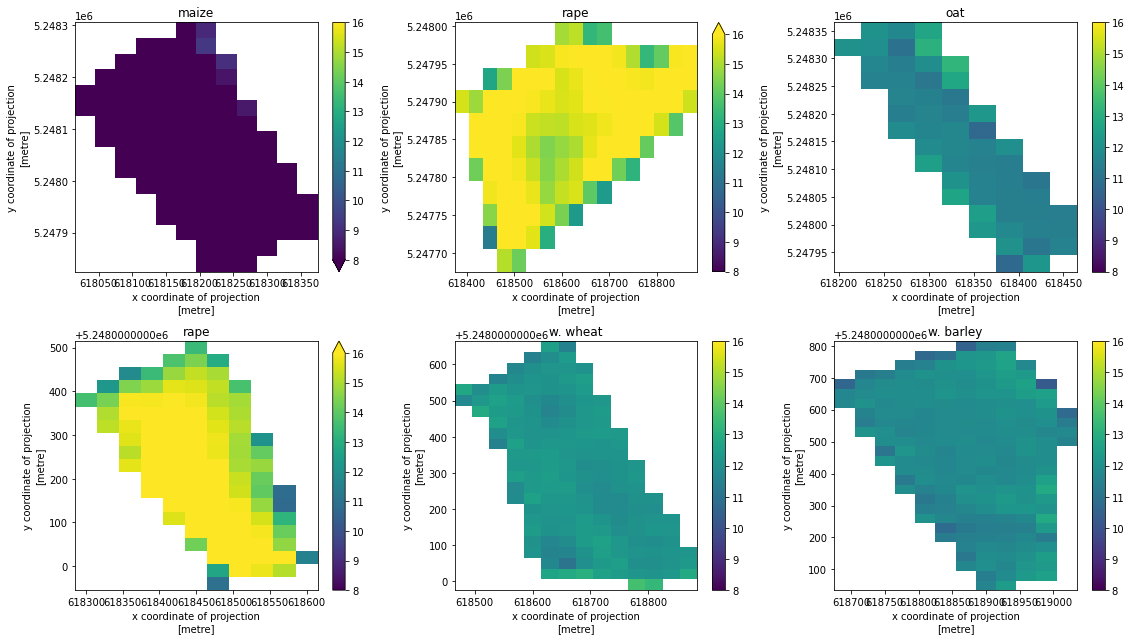

In [53]:
_, axs = plt.subplots(2, 3, figsize=(16, 9), tight_layout=True)
axs = axs.flatten()

dmp_tifs = []

for i, row in gdf_utm.iterrows():
    ax = axs[i]
    
    ndvi_all_i = ndvi_all.rio.clip([row.geometry])
    ndvi_all_i = ndvi_all_i.sel(date=slice(row.planting, row.harvesting))
    
    
    ndvi_max = ndvi_all_i.max(dim='date') #.band_data.plot()
    ndvi_min = ndvi_all_i.min(dim='date')
    
    fpar = (ndvi_all_i - ndvi_min) / (ndvi_max - ndvi_min) * (fpar_max - fpar_min)
    
    # df_met_i = df_met[row.planting: row.harvesting]  # fails for corn
    df_met_i = df_met[fpar.date.min().values:fpar.date.max().values]
    
    fpar['rin_mean'] = df_met_i.rin_mean
    fpar['ta_stress'] = df_met_i.ta_stress
    fpar['vpd_stress'] = df_met_i.vpd_stress
    
    gpp = lue_max * fpar.ta_stress * fpar.vpd_stress * fpar.band_data * fpar.rin_mean * (60*60*24 * 1e-6) * 0.45  # gC m-2 day-1
    dmp = gpp / 12 * (12+2+16) * 0.5 * 1e4 * 1e-6  # t ha-1
    
    dmp_seasonal = dmp.sum(dim='date')
    dmp_tifs.append(dmp_seasonal)
    
    dmp_seasonal.where(dmp_seasonal != 0).plot(ax=ax, vmin=8, vmax=16)
    ax.set_title(row['2022_crop'])
    
    gdf_utm.loc[i, 'dmp_sum'] = dmp_seasonal.mean().values

In [54]:
gdf_utm

,id,area,planting,harvesting,yield,2022_crop,geometry,los,et_sum,wue,dmp_sum
0,1,9.940,2022-05-11,2022-10-24,10.1,maize,"POLYGON ((618196.610 5248325.801, 618390.967 5...",166,142.273508,70.990026,3.506532
1,6,10.046,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618380.730 5247899.310, 618382.926 5...",317,282.279199,10.627776,9.192622
2,2,4.939,2021-11-14,2022-07-21,6.0,oat,"POLYGON ((618287.225 5248387.606, 618483.076 5...",249,158.497976,37.855373,4.777500
3,2,9.267,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618483.076 5247950.694, 618287.225 5...",317,238.944472,12.555218,7.621446
4,4,15.231,2021-11-14,2022-07-20,6.3,w. wheat,"POLYGON ((618663.927 5248679.234, 618893.223 5...",248,223.816096,28.148110,6.381886
5,4,17.791,2021-10-13,2022-07-04,7.3,w. barley,"POLYGON ((618893.223 5248019.231, 618663.927 5...",264,257.171402,28.385738,7.428676


In [55]:
gdf_utm['wue_dmp'] = gdf_utm.dmp_sum / gdf_utm.et_sum * 1e3  # kg mm-1 ha-1
gdf_utm

,id,area,planting,harvesting,yield,2022_crop,geometry,los,et_sum,wue,dmp_sum,wue_dmp
0,1,9.940,2022-05-11,2022-10-24,10.1,maize,"POLYGON ((618196.610 5248325.801, 618390.967 5...",166,142.273508,70.990026,3.506532,24.646415
1,6,10.046,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618380.730 5247899.310, 618382.926 5...",317,282.279199,10.627776,9.192622,32.565707
2,2,4.939,2021-11-14,2022-07-21,6.0,oat,"POLYGON ((618287.225 5248387.606, 618483.076 5...",249,158.497976,37.855373,4.777500,30.142341
3,2,9.267,2021-08-30,2022-07-13,3.0,rape,"POLYGON ((618483.076 5247950.694, 618287.225 5...",317,238.944472,12.555218,7.621446,31.896305
4,4,15.231,2021-11-14,2022-07-20,6.3,w. wheat,"POLYGON ((618663.927 5248679.234, 618893.223 5...",248,223.816096,28.148110,6.381886,28.513971
5,4,17.791,2021-10-13,2022-07-04,7.3,w. barley,"POLYGON ((618893.223 5248019.231, 618663.927 5...",264,257.171402,28.385738,7.428676,28.886088


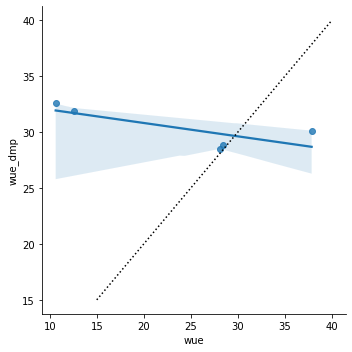

In [56]:
g = sns.lmplot(data=gdf_utm[gdf_utm['2022_crop'] != 'maize'], x='wue', y='wue_dmp')
lims = [15, 40]
g.axes.flatten()[0].plot(lims, lims, 'k:')

### dmp wue maps

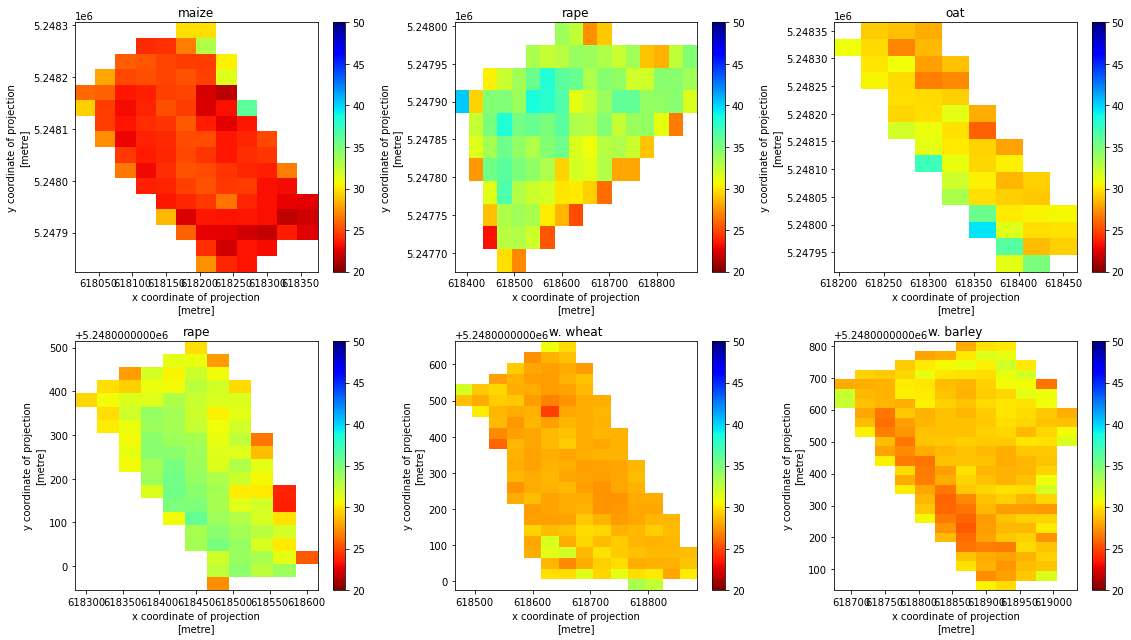

In [57]:
_, axs = plt.subplots(2, 3, figsize=(16, 9), tight_layout=True)
axs = axs.flatten()

for i in gdf_utm.index:
    ax = axs[i]
    crop = gdf_utm['2022_crop'][i]
    wue_dmp = dmp_tifs[i] / et_tifs[i] * 1e3 

    wue_dmp.plot(ax=ax, cmap='jet_r', vmin=20, vmax=50)  # RdBu
    ax.set_title(crop)

# BONUS 2*
# 5. Comparison of our simulations to potential ET (PET)

## Tunc formula

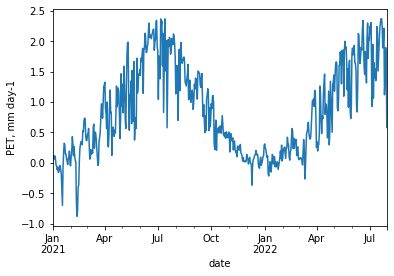

In [58]:
pet_tunc = 1 * 0.013 * (df_met.ta_mean / (df_met.ta_mean + 15)) * (23.886 * df_met.rin_mean * 1e-6*(60*60*24) + 50) / (2.45)
pet_tunc.plot()
plt.ylabel('PET, mm day-1');

## Pristley-Taylor

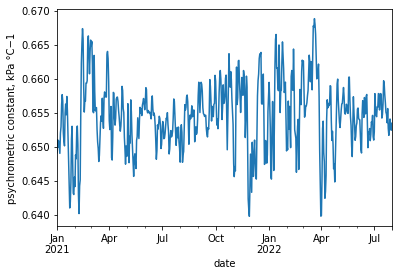

In [59]:
delta = 4098*0.6108*np.exp((17.27*df_met.ta_mean)/(df_met.ta_mean+237.3))/(df_met.ta_mean+237.3)**2
gamma = 0.00163*df_met.p_mean/2.45
gamma.plot()
plt.ylabel('psychrometric constant, kPa °C−1');

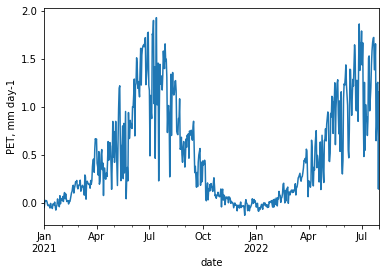

In [60]:
pet_pt = 1.26 * (delta / (delta + gamma)) * (df_met.rn_24 * 60*60*24 * 1e-6) / 2.45
pet_pt.plot()
plt.ylabel('PET, mm day-1');

## our simulated ET

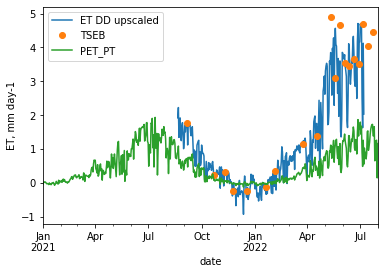

In [61]:
df_met['ET'] = df_met.EF * df_met.rn_24 * 0.035
df_met.ET.plot(label='ET DD upscaled')
df.et_24.plot(style='o', label='TSEB')
pet_pt.plot(label='PET_PT')
plt.legend()
plt.ylabel('ET, mm day-1');